In [1]:
import os, logging, random, gc, time, warnings
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

# Check the TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

2025-08-01 15:19:16.890964: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 15:19:16.905505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754086756.920472  517246 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754086756.925024  517246 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754086756.936326  517246 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
Num GPUs Available: 1


/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CFG:
    seed = 42
    debug = False
    print_freq = 100
    num_workers = 1

    # Project root
    PROJECT_ROOT_DIR = Path.cwd().parents[2]

    OUTPUT_DIR = PROJECT_ROOT_DIR / 'data/working/'
    SPECTROGRAMS_DIR = OUTPUT_DIR / 'birdclef25-mel-spectrograms/'
    
    train_data_dir = PROJECT_ROOT_DIR / 'data/raw/train_audio'
    train_csv = PROJECT_ROOT_DIR / 'data/raw/train.csv'
    taxonomy_csv = PROJECT_ROOT_DIR / 'data/raw/taxonomy.csv'
    working_df_path = PROJECT_ROOT_DIR / 'configs/work_df_w_split_info.csv'

    # Define subfolders in OUTPUT_DIR
    MODELS_DIR = OUTPUT_DIR / 'models'
    PLOTS_DIR = OUTPUT_DIR / 'plots'
    RESULTS_CSV_DIR = OUTPUT_DIR / 'result_csvs'

    # Create directories if they don't exist
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)
    os.makedirs(RESULTS_CSV_DIR, exist_ok=True)

    # Parametric input dim (32, 64, or 256)
    # This would be used to also control the input path and shape (see below)
    input_dim = 256 # Default to 32
    
    # Derived paths and shapes
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR / f'birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy'
    
    @property  # Add this to make it dynamic
    def TARGET_SHAPE(self):
        return (self.input_dim, self.input_dim)
    
    in_channels = 1  # Single channel
    LOAD_DATA = True # Load data from precomputed spectrograms
    num_classes = 4  # 4 high-level classes

    epochs = 10
    batch_size = 128
    
    n_fold = 4
    selected_folds = [0,1,2,3]  # Use all folds by default

    lr = 5e-4 
    weight_decay = 1e-5
    min_lr = 1e-6
    
    use_augmentation = True  # Toggle augmentation on/off
    use_oversampling = True # Toggle oversampling on/off
    use_class_weights = False # Toggle class weights on/off

    # Augmentation params
    aug_prob = 0.7 if use_augmentation else 0.0  # Probability of applying any augmentation
    mixup_alpha = 0.2 if use_augmentation else 0.0  # MixUp alpha (beta distribution)
    noise_std = 0.1  # Std dev for Gaussian noise
    max_time_shift = 0.2  # Fraction of time axis to shift (e.g., 20%)
    max_freq_shift = 0.2  # Fraction of freq axis to shift
    max_mask_time = 0.15  # Fraction of time axis to mask
    max_mask_freq = 0.15 # Fraction of freq axis to mask

    oversampling_factors = None  # Will be set dynamically based on class frequencies
    
    # Derived model save name
    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:
            suffix += "_aug"
        if self.use_oversampling:
            suffix += "_os"
        if self.use_class_weights:
            suffix += "_cw"
        return f"base_model_{str(self.input_dim)}{suffix}.keras"

    def update_debug_settings(self):
        # Only run 1 fold and 6 epochs in debug mode, we will use this as a quick test
        if self.debug:
            self.epochs = 3
            self.selected_folds = [0]

cfg = CFG()

random.seed(cfg.seed)
np.random.seed(cfg.seed)
tf.random.set_seed(cfg.seed)

In [3]:
class SpecTimeMask(layers.Layer):
    """Zero-out a random contiguous time window (width axis)."""
    def __init__(self, max_frac=0.15, **kw):
        super().__init__(**kw)
        self.max_frac = max_frac

    def call(self, x, training=None):
        if not training:
            return x
        t = tf.shape(x)[2]                               # width/time
        mask = tf.random.uniform([], 0, self.max_frac)   # 0–max_frac of the width
        w   = tf.cast(mask * tf.cast(t, tf.float32), tf.int32)
        start = tf.random.uniform([], 0, t - w, dtype=tf.int32)
        zeros = tf.zeros_like(x[:, :, start:start + w, :])
        return tf.concat([x[:, :, :start, :], zeros, x[:, :, start + w:, :]], axis=2)

class SpecFreqMask(layers.Layer):
    """Zero-out a random contiguous frequency window (height axis)."""
    def __init__(self, max_frac=0.15, **kw):
        super().__init__(**kw)
        self.max_frac = max_frac

    def call(self, x, training=None):
        if not training:
            return x
        h = tf.shape(x)[1]                               # height/freq
        mask = tf.random.uniform([], 0, self.max_frac)
        w   = tf.cast(mask * tf.cast(h, tf.float32), tf.int32)
        start = tf.random.uniform([], 0, h - w, dtype=tf.int32)
        zeros = tf.zeros_like(x[:, start:start + w, :, :])
        return tf.concat([x[:, :start, :, :], zeros, x[:, start + w:, :, :]], axis=1)


def data_generator(df, cfg, spectrograms, is_train=True, yield_weight=True):
    """
    Generator function to yield spectrograms and targets for training or evaluation.
    If `is_train` is True, applies augmentations based on cfg settings.
    If `yield_weight` is True, yields sample weights based on class distribution.
    """
    rows = df.to_dict('records')
    
    if cfg.use_oversampling and is_train:
        resampled_rows = []
        for cls, factor in cfg.oversampling_factors.items():
            class_rows = [r for r in rows if r['y_species_encoded'] == cls]
            
            if factor == 1:  # No resampling
                multiplier = 1
                resampled_rows.extend(class_rows)
            elif factor > 1:  # Oversampling
                multiplier = int(factor)
                resampled_rows.extend(class_rows * multiplier)
            elif 0 < factor < 1:  # Downsampling
                n_samples = int(len(class_rows) * factor)
                downsampled = random.sample(class_rows, min(n_samples, len(class_rows)))
                resampled_rows.extend(downsampled)
            # factor == 0 would mean exclude this class entirely
            
        random.shuffle(resampled_rows)
        rows = resampled_rows

    for idx, row in enumerate(rows):
        samplename = row['samplename']
        spec = spectrograms.get(samplename, np.zeros((*cfg.TARGET_SHAPE, cfg.in_channels), dtype=np.float32))
        spec = np.expand_dims(spec, axis=-1)  # (H, W, 1)
        spec = tf.convert_to_tensor(spec, dtype=tf.float32)  # To TF tensor for ops
        
        target = to_categorical(row['y_species_encoded'], num_classes=cfg.num_classes)
        
        if is_train and np.random.rand() < cfg.aug_prob and cfg.mixup_alpha > 0:
            # MixUp: Sample another instance and mix
            other_idx = np.random.randint(len(rows))
            other_row = rows[other_idx]
            other_spec = spectrograms.get(other_row['samplename'], np.zeros((*cfg.TARGET_SHAPE, cfg.in_channels), dtype=np.float32))
            other_spec = np.expand_dims(other_spec, axis=-1)
            other_spec = tf.convert_to_tensor(other_spec, dtype=tf.float32)
            
            other_target = to_categorical(other_row['y_species_encoded'], num_classes=cfg.num_classes)
            
            lam = stats.beta.rvs(cfg.mixup_alpha, cfg.mixup_alpha)
            
            spec = lam * spec + (1 - lam) * other_spec
            target = lam * target + (1 - lam) * other_target
        
        spec = spec.numpy()  # Back to numpy if needed for yield
        
        if yield_weight:
            sample_weight = class_weights[row['y_species_encoded']]  # Use original class for weight
            yield spec, target, sample_weight
        else:
            yield spec, target

In [4]:
print("\nLoading combined train data...")
full_df = pd.read_csv(cfg.working_df_path)

# Combine train and val as "combined train"
combined_train_val_df = full_df[full_df['split'].isin(['train', 'val'])].reset_index(drop=True)

# Compute class counts in combined train/val
class_counts = combined_train_val_df['y_species_encoded'].value_counts().to_dict()
print("Class counts in train/val:", class_counts)

max_count = max(class_counts.values())
oversampling_factors = {}
for cls, count in class_counts.items():
    if count == 0:
        oversampling_factors[cls] = 0  # Avoid division by zero
    else:
        factor = min(round(max_count / count), 50)  # Cap at 50 to avoid extreme repetition
        oversampling_factors[cls] = factor if factor > 1 else 1  # Min 1 for majority

# For majority (Aves, class 1), explicitly set to 0.5 for downsampling
oversampling_factors[1] = 1

print("Computed oversampling factors:", oversampling_factors)

# Update CFG
cfg.oversampling_factors = oversampling_factors

combined_train_val_df.head()


Loading combined train data...
Class counts in train/val: {1: 22118, 0: 466, 3: 143, 2: 124}
Computed oversampling factors: {1: 1, 0: 47, 3: 50, 2: 50}


,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split
0,1139490,0.0,1139490/CSA36389.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36389,Insecta,2,train
1,1192948,0.0,1192948/CSA36358.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36358,Insecta,2,train
2,1192948,0.0,1192948/CSA36366.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36366,Insecta,2,train
3,1192948,0.0,1192948/CSA36373.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36373,Insecta,2,val
4,1194042,0.0,1194042/CSA18783.ogg,2,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1194042-CSA18783,Insecta,2,val


In [5]:
# Load pre-computed mel spectrograms
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
print(f"Example spectrogram shape: {spectrograms['1139490-CSA36389'].shape}")

# This is a dict, the samplename '1139490-CSA36389' is the key
spectrograms['1139490-CSA36389']

Loaded 28564 pre-computed mel spectrograms
Example spectrogram shape: (256, 256)


array([[0.6860932 , 0.63555586, 0.6695411 , ..., 0.83289945, 0.8271354 ,
        0.7059211 ],
       [0.68805015, 0.63310075, 0.66653323, ..., 0.8213653 , 0.82061225,
        0.71397114],
       [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
        0.73007125],
       ...,
       [0.23160961, 0.25438875, 0.24364811, ..., 0.20537259, 0.20583257,
        0.20394798],
       [0.22382578, 0.2653285 , 0.27449802, ..., 0.2096595 , 0.18890202,
        0.21603397],
       [0.21993388, 0.2707984 , 0.28992295, ..., 0.21180296, 0.18043673,
        0.22207697]], dtype=float32)

In [6]:
# Custom class weights based on the distribution in the combined train/val set
@tf.keras.utils.register_keras_serializable()
class AddClsToken(tf.keras.layers.Layer):
    def __init__(self, projection_dim, **kwargs):
        super(AddClsToken, self).__init__(**kwargs)
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.cls_token = self.add_weight(
            shape=(1, 1, self.projection_dim),
            initializer="zeros",
            trainable=True,
            name="cls_token"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls = tf.tile(self.cls_token, [batch_size, 1, 1])
        return tf.concat([cls, inputs], axis=1)

    def get_config(self):
        config = super(AddClsToken, self).get_config()
        config.update({"projection_dim": self.projection_dim})
        return config

@tf.keras.utils.register_keras_serializable()
def macro_f1_fn(y_true, y_pred):
    """Pure TensorFlow macro F1 implementation"""
    y_true_labels = tf.argmax(y_true, axis=-1)
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    num_classes = tf.shape(y_true)[-1]
    f1_scores = []
    
    for class_id in range(4):  # Use your num_classes=4
        true_class = tf.equal(y_true_labels, class_id)
        pred_class = tf.equal(y_pred_labels, class_id)
        
        tp = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(true_class), pred_class), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(true_class, tf.logical_not(pred_class)), tf.float32))
        
        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        
        f1_scores.append(f1)
    
    return tf.reduce_mean(tf.stack(f1_scores))

def categorical_focal_loss(alpha=0.25, gamma=2.0):
    """
    Multi-class focal loss for imbalanced datasets.
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return categorical_focal_loss_fixed

In [ ]:
def build_gpu_augmenter(cfg):
    return tf.keras.Sequential([
        layers.GaussianNoise(stddev=cfg.noise_std),
        # width = time, height = frequency in your mel-specs
        layers.RandomTranslation(
            height_factor=cfg.max_freq_shift / cfg.TARGET_SHAPE[0],
            width_factor=cfg.max_time_shift / cfg.TARGET_SHAPE[1],
            fill_mode='reflect'),
        SpecTimeMask(max_frac=cfg.max_mask_time),
        SpecFreqMask(max_frac=cfg.max_mask_freq),
    ], name="gpu_augment")


def get_vit_model(cfg):
    """
    Build a ViT-style spectrogram classifier with optional GPU-accelerated
    augmentation embedded in the model graph.
    """
    # ───────────────────────────────────────── input & (optional) aug
    input_shape = (*cfg.TARGET_SHAPE, cfg.in_channels)          # e.g. (32, 32, 1)
    inputs = layers.Input(shape=input_shape)

    x = inputs
    if cfg.use_augmentation:
        gpu_aug = build_gpu_augmenter(cfg)                      # runs on GPU
        x = gpu_aug(x, training=True)                           # keep aug ON in train

    # ───────────────────────────────────────── patch + embed stem
    patch_size       = 4
    projection_dim   = 128
    h_patches        = cfg.TARGET_SHAPE[0] // patch_size        # height  // 4
    w_patches        = cfg.TARGET_SHAPE[1] // patch_size        # width   // 4
    num_patches      = h_patches * w_patches                    # total patches

    # Patch extraction
    patches = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(x)
    patches = layers.Reshape((num_patches, projection_dim))(patches)

    # Add CLS token
    x = AddClsToken(projection_dim)(patches)

    # Positional embedding
    positions = tf.range(start=0, limit=num_patches + 1, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)(positions)
    x = x + position_embedding

    # ───────────────────────────────────────── Transformer encoder
    num_layers = 6  # Assuming this from typical ViT configs; adjust if different
    num_heads = 4
    mlp_dim = 256
    dropout_rate = 0.3  # Set to 0.3-0.5 as recommended; start with 0.3

    for _ in range(num_layers):
        # Multi-Head Attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim // num_heads)(x, x)
        attn_output = layers.Dropout(dropout_rate)(attn_output)  # Add dropout after attention
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # MLP
        mlp = layers.Dense(mlp_dim, activation='gelu')(x)
        mlp = layers.Dense(projection_dim)(mlp)
        mlp = layers.Dropout(dropout_rate)(mlp)  # Add dropout after MLP
        x = layers.Add()([x, mlp])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    # ───────────────────────────────────────── head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = x[:, 0, :]  # CLS token
    outputs = layers.Dense(cfg.num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    return model


# # Chekc the model struture
# test_model = get_vit_model(cfg)

# test_model.compile(
#     optimizer = tf.keras.optimizers.AdamW(cfg.lr, weight_decay=cfg.weight_decay),
#     loss      = tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=0.25),
#     metrics   = [
#         "accuracy",
#         tf.keras.metrics.AUC(name="auc"),
#         tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
#         macro_f1_fn,                    # your custom metric
#     ],
# )

# # Get the model summary
# test_model.summary()

# # Clean up
# del test_model
# gc.collect()

In [8]:
# Sanity check: Print class counts across full dataset
class_counts = combined_train_val_df['y_species_encoded'].value_counts().sort_index()
print("Full dataset class distribution (0: Amphibia, 1: Aves, 2: Insecta, 3: Mammalia):")
print(class_counts)
print(f"Imbalance ratio: Aves / Total = {class_counts[1] / class_counts.sum():.2%}")

# Create class mapping dictionary
class_mapping_dict = {
    0: 'Amphibia',
    1: 'Aves',
    2: 'Insecta',
    3: 'Mammalia'
}

# Sanity check 2: Inspect a batch from the generator
gen = data_generator(combined_train_val_df[combined_train_val_df['split'] == 'train'], cfg, spectrograms, is_train=True, yield_weight=False)
batch_specs, batch_labels = next(gen)  # Get one item (since generator is per-sample)
print("\nExample batch label (one-hot):", batch_labels)
print("Class order matches Dense layer: [Amphibia, Aves, Insecta, Mammalia]")

# Create class weights for imbalanced dataset
classes = np.unique(combined_train_val_df['y_species_encoded'])
labels = combined_train_val_df['y_species_encoded'].values

if cfg.use_class_weights:
    print("\nComputing class weights...")
    class_weights = compute_class_weight('balanced', classes=classes, y=labels)
    class_weights_dict = dict(zip(classes, class_weights))
    print("Computed class weights:", class_weights_dict)
else:
    print("\nUsing uniform class weights")
    class_weights_dict = {i: 1.0 for i in range(cfg.num_classes)}  # Uniform weights when toggled off
    


Full dataset class distribution (0: Amphibia, 1: Aves, 2: Insecta, 3: Mammalia):
y_species_encoded
0      466
1    22118
2      124
3      143
Name: count, dtype: int64
Imbalance ratio: Aves / Total = 96.79%

Example batch label (one-hot): [0. 0. 0. 1.]
Class order matches Dense layer: [Amphibia, Aves, Insecta, Mammalia]

Using uniform class weights


I0000 00:00:1754086768.653891  517246 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22293 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:50:00.0, compute capability: 8.0


In [9]:
def make_ds(df, is_train, with_weight=True):
    sig = (
        tf.TensorSpec((*cfg.TARGET_SHAPE, cfg.in_channels), tf.float32),
        tf.TensorSpec((cfg.num_classes,), tf.float32),
    )
    if with_weight:
        sig += (tf.TensorSpec((), tf.float32),)

    gen = lambda: data_generator(df, cfg, spectrograms,
                                 is_train=is_train, yield_weight=with_weight)

    return tf.data.Dataset.from_generator(gen, output_signature=sig) \
             .shuffle(10_000 if is_train else 1) \
             .prefetch(tf.data.AUTOTUNE)   

In [10]:
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [11]:
cfg.model_save_name

'base_model_256_aug_os.keras'

In [12]:
# Simple 80/20 stratified split
train_df, val_df = train_test_split(
    combined_train_val_df, test_size=0.2,
    stratify=combined_train_val_df['y_species_encoded'],
    random_state=cfg.seed
    )

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df, cfg, spectrograms, is_train=True, yield_weight=False),
    output_signature=(
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df, cfg, spectrograms, is_train=False, yield_weight=False),
    output_signature=(
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
    )
)


train_ds = (
    train_ds.shuffle(buffer_size=10000)      # shuffle single examples
            .batch(cfg.batch_size)                   # batch once
            .prefetch(tf.data.AUTOTUNE)
)

val_ds = val_ds.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

model = get_vit_model(cfg)

model.compile(
    optimizer = tf.keras.optimizers.AdamW(cfg.lr, weight_decay=cfg.weight_decay),
    loss      = tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=0.25),
    metrics   = [
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
        macro_f1_fn,                    # your custom metric
    ],
)

# Callbacks
cb_list = []

model_checkpoint = ModelCheckpoint(
    "best_model.keras", 
    monitor='val_macro_f1', 
    mode='max', 
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_macro_f1_fn',  # Monitor validation Macro F1
    patience=3,
    mode='max',  # Maximize F1
    restore_best_weights=True  # Restore best model
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_macro_f1_fn',  # Monitor validation Macro F1
    factor=0.5,
    patience=2,
    min_lr=cfg.min_lr
)

log_csv_path = cfg.RESULTS_CSV_DIR / f"training_log_{cfg.input_dim}{cfg.model_save_name.replace('base_model_', '').replace('.keras', '')}.csv"
csv_logger = tf.keras.callbacks.CSVLogger(log_csv_path, append=True, separator=',')

cb_list = [model_checkpoint, early_stop, csv_logger, lr_reduce]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = cfg.epochs,
    callbacks       = cb_list,
)

# After model.fit (training complete), optimize thresholds on val
val_specs, val_targets = [], []
for spec, target in val_ds.unbatch():
    val_specs.append(spec.numpy())
    val_targets.append(target.numpy())
val_specs = np.array(val_specs)
val_targets = np.argmax(np.array(val_targets), axis=1)

val_preds_prob = model.predict(val_specs)

# Optimize thresholds per class
optimal_thresholds = [0.5] * cfg.num_classes  # Default
for class_id in range(cfg.num_classes):
    class_probs = val_preds_prob[:, class_id]
    class_true = (val_targets == class_id).astype(int)
    
    thresholds = np.linspace(0.1, 0.9, 81)  # Test 0.1 to 0.9
    f1_scores = [f1_score(class_true, (class_probs >= th).astype(int)) for th in thresholds]
    optimal_thresholds[class_id] = thresholds[np.argmax(f1_scores)]

print("Optimal thresholds per class:", optimal_thresholds)

# Save the model
model_save_path = cfg.MODELS_DIR / cfg.model_save_name
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Train size: 18280, Val size: 4571
Epoch 1/10


2025-08-01 15:19:51.957786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 7840 of 10000
2025-08-01 15:19:54.625257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1754086795.058460  517314 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-01 15:20:05.291149: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.02GiB (rounded to 34376517632)requested by op StatefulPartitionedCall/functional_1_1/multi_head_attention_1/einsum/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-08-01 15:20:05.291369: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-08-01 15:20:05.291377: I externa

ResourceExhaustedError: Graph execution error:

Detected at node functional_1_1/multi_head_attention_1/einsum/Einsum defined at (most recent call last):
  File "/data/homezvol2/ddlin/.local/share/uv/python/cpython-3.10.2-linux-x86_64-gnu/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/data/homezvol2/ddlin/.local/share/uv/python/cpython-3.10.2-linux-x86_64-gnu/lib/python3.10/runpy.py", line 86, in _run_code

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/data/homezvol2/ddlin/.local/share/uv/python/cpython-3.10.2-linux-x86_64-gnu/lib/python3.10/asyncio/base_events.py", line 595, in run_forever

  File "/data/homezvol2/ddlin/.local/share/uv/python/cpython-3.10.2-linux-x86_64-gnu/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once

  File "/data/homezvol2/ddlin/.local/share/uv/python/cpython-3.10.2-linux-x86_64-gnu/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 397, in dispatch_shell

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 368, in execute_request

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 752, in execute_request

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 455, in do_execute

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 577, in run_cell

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_517246/910084383.py", line 78, in <module>

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 183, in call

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 648, in call

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/layers/attention/multi_head_attention.py", line 557, in call

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/layers/attention/multi_head_attention.py", line 473, in _compute_attention

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/ops/nn.py", line 2704, in dot_product_attention

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 1076, in dot_product_attention

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 1027, in _dot_product_attention_xla

OOM when allocating tensor with shape[128,4,4097,4097] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node functional_1_1/multi_head_attention_1/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_24997]

In [ ]:
def evaluate_on_test(model, cfg, spectrograms, test_df):
    """
    Evaluate the model on the test dataset.
    
    Parameters:
    -----------
    model: Trained Keras model
    cfg: Configuration object with attributes like TARGET_SHAPE, in_channels, num_classes, batch_size
    spectrograms: Dictionary of precomputed spectrograms
    test_df: DataFrame with test samples
    
    Returns:
    --------
    y_true: One-hot encoded true labels (numpy array)
    y_pred_prob: Predicted probabilities (numpy array)  # Updated docstring
    """
    # Create test dataset (no augmentation, no weights)
    test_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(test_df, cfg, spectrograms, is_train=False, yield_weight=False),
        output_signature=(
            tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
        )
    )
    test_ds = test_ds.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Ground truth labels (one-hot encoded)
    y_true = np.array([to_categorical(row['y_species_encoded'], num_classes=cfg.num_classes) 
                       for _, row in test_df.iterrows()])
    
    # Get predictions (probabilities)
    preds_prob = model.predict(test_ds, verbose=1)
    
    # Optional: Apply per-class thresholds and get labels (but compute metrics on probs)
    preds_adjusted = np.zeros_like(preds_prob)
    for class_id in range(cfg.num_classes):
        preds_adjusted[:, class_id] = (preds_prob[:, class_id] >= optimal_thresholds[class_id]).astype(int)
    y_pred_labels = np.argmax(preds_adjusted, axis=1)  # Labels, if needed elsewhere
    
    # Clear session and collect garbage
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Compute overall metrics using probabilities
    test_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, preds_prob).numpy()
    test_auc = tf.keras.metrics.AUC(multi_label=False)(y_true, preds_prob).numpy()  # Multiclass AUC (one-vs-rest)
    test_acc = tf.keras.metrics.CategoricalAccuracy()(y_true, preds_prob).numpy()
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    return y_true, preds_prob  # Return probabilities for downstream use
def plot_test_evaluation(y_true, y_pred, class_mapping=None, cfg=None):
    """
    Plot confusion matrix, probability distributions, and print classification report for test evaluation.
    
    Parameters:
    -----------
    y_true: One-hot encoded true labels (numpy array)
    y_pred: Predicted probabilities (numpy array)
    class_mapping: dict mapping class indices to names (e.g., {0: 'Amphibia', 1: 'Aves'})
    cfg: Configuration object with RESULTS_CSV_DIR, input_dim, model_save_name
    """
    # Default mapping if none provided
    if class_mapping is None:
        class_mapping = {i: f'Class_{i}' for i in range(y_true.shape[1])}
    
    # Get class names in order
    class_names = [class_mapping[i] for i in range(len(class_mapping))]
    
    # Convert to class labels
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].figure.colorbar(im, ax=axes[0])
    axes[0].set(xticks=np.arange(cm.shape[1]),
                yticks=np.arange(cm.shape[0]),
                xticklabels=class_names, 
                yticklabels=class_names,
                title='Confusion Matrix',
                ylabel='True label',
                xlabel='Predicted label')
    
    # Rotate x-tick labels
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations to CM
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
    
    # Plot 2: Per-class probability distributions
    for idx, class_name in enumerate(class_names):
        axes[1].hist(y_pred[:, idx], bins=30, alpha=0.5, label=class_name)
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Predicted Probabilities by Class')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save classification report as CSV if cfg is provided
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    if cfg is not None:
        suffix = cfg.model_save_name.replace('base_model_', '').replace('.keras', '')
        csv_path = cfg.RESULTS_CSV_DIR / f"classification_report_{cfg.input_dim}{suffix}.csv"
        df_report.to_csv(csv_path)
        print(f"Classification report saved to: {csv_path}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

def plot_training_diagnostics(history, cfg, y_true, y_pred, class_mapping_dict):
    """
    Plot training diagnostics: learning curves, normalized confusion matrix, and per-class metrics bar plot.
    Saves plots to disk after displaying.
    
    Parameters:
    -----------
    history: Keras history object from model.fit()
    cfg: Configuration object with PLOTS_DIR, input_dim, model_save_name
    y_true: One-hot encoded true labels (numpy array)
    y_pred: Predicted probabilities (numpy array)
    class_mapping_dict: dict mapping class indices to names
    """
    # Combined Learning Curves
    metrics_to_plot = ['loss', 'macro_f1_fn', 'pr_auc', 'auc', 'accuracy', 'f1']
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.flatten()
    for i, metric in enumerate(metrics_to_plot):
        if metric in history.history:
            axs[i].plot(history.history[metric], label=f'Train {metric}')
            if f'val_{metric}' in history.history:
                axs[i].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
            axs[i].set_title(f'{metric.capitalize()} Curve')
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel(metric.capitalize())
            axs[i].legend()
    plt.tight_layout()
    plt.show()  # Display the combined curves plot
    
    # Save learning curves
    suffix = cfg.model_save_name.replace('base_model_', '').replace('.keras', '')
    plot_path = cfg.PLOTS_DIR / f"training_curves_{cfg.input_dim}{suffix}.png"
    plt.savefig(plot_path)
    plt.close(fig)
    print(f"Training curves saved to: {plot_path}")

    # Convert to class labels for CM and report
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    class_names = list(class_mapping_dict.values())

    # Confusion Matrix (normalized)
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()  # Display the confusion matrix
    
    # Save CM
    cm_plot_path = cfg.PLOTS_DIR / f"confusion_matrix_{cfg.input_dim}{suffix}.png"
    plt.savefig(cm_plot_path)
    plt.close()
    print(f"Confusion matrix saved to: {cm_plot_path}")

    # Per-Class Bar Plot
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose().iloc[:-3, :3]  # Precision, Recall, F1 per class
    df_report.plot(kind='bar', figsize=(10, 6))
    plt.title('Per-Class Precision, Recall, F1')
    plt.show()  # Display the per-class metrics plot
    
    # Save per-class metrics
    per_class_plot_path = cfg.PLOTS_DIR / f"per_class_metrics_{cfg.input_dim}{suffix}.png"
    plt.savefig(per_class_plot_path)
    plt.close()
    print(f"Per-class metrics saved to: {per_class_plot_path}")

Test size: 5713
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step

Test Loss: 0.8675
Test AUC: 0.9299
Test Accuracy: 0.7884


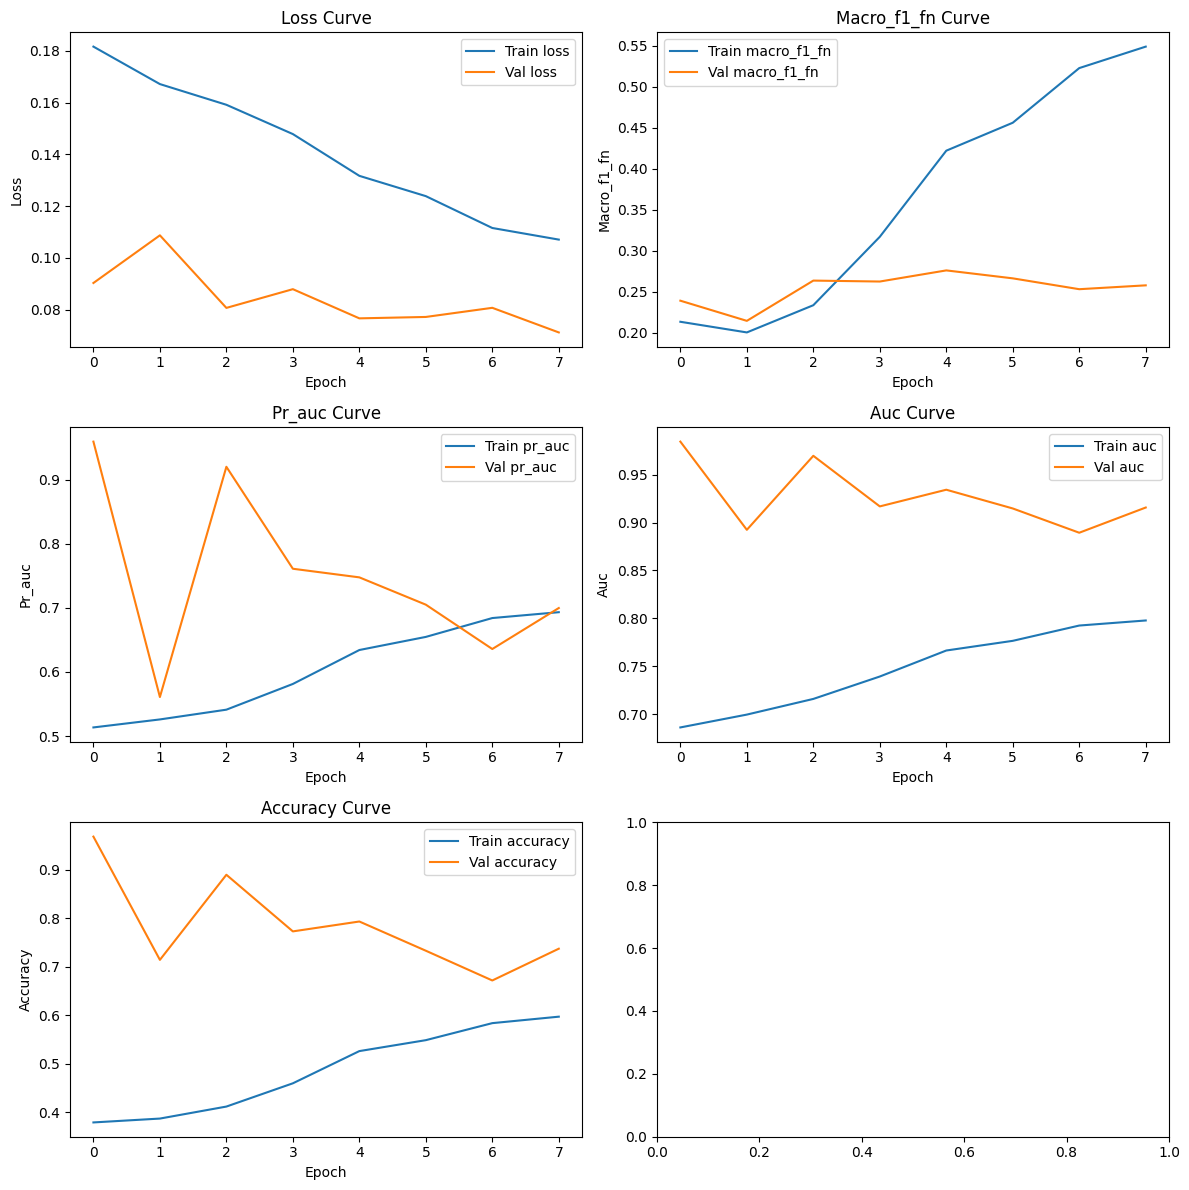

Training curves saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/training_curves_6464_aug_os.png


<Figure size 640x480 with 0 Axes>

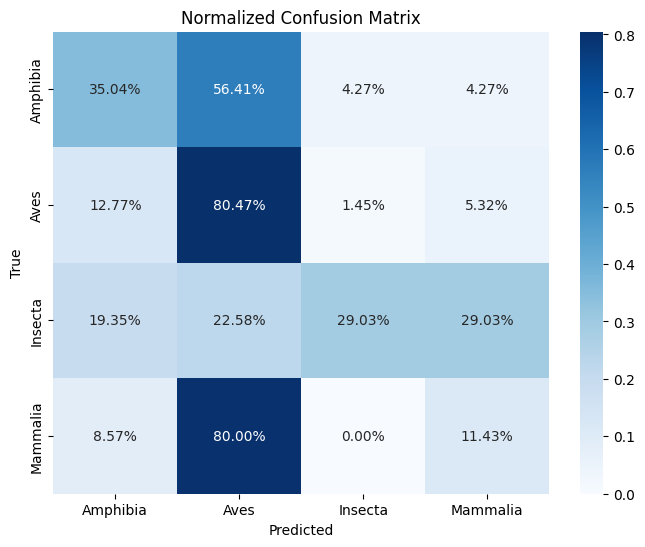

Confusion matrix saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/confusion_matrix_6464_aug_os.png


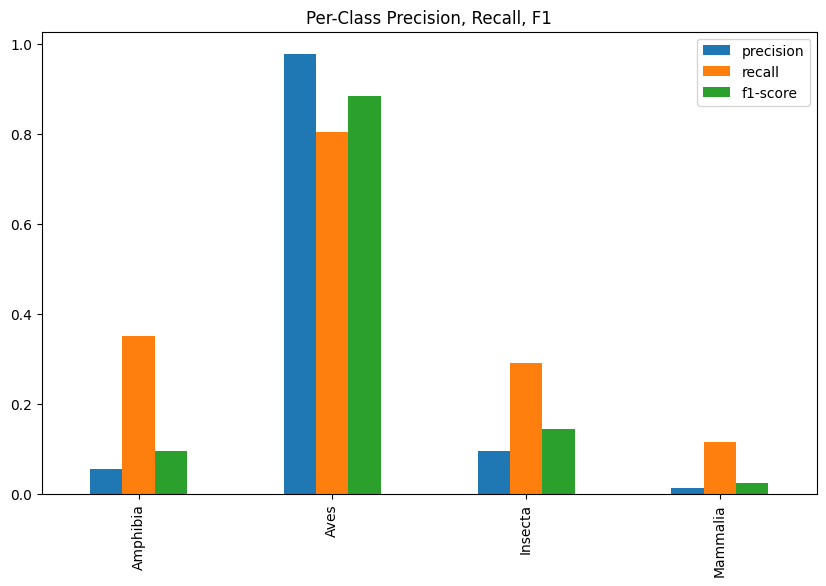

Per-class metrics saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/per_class_metrics_6464_aug_os.png


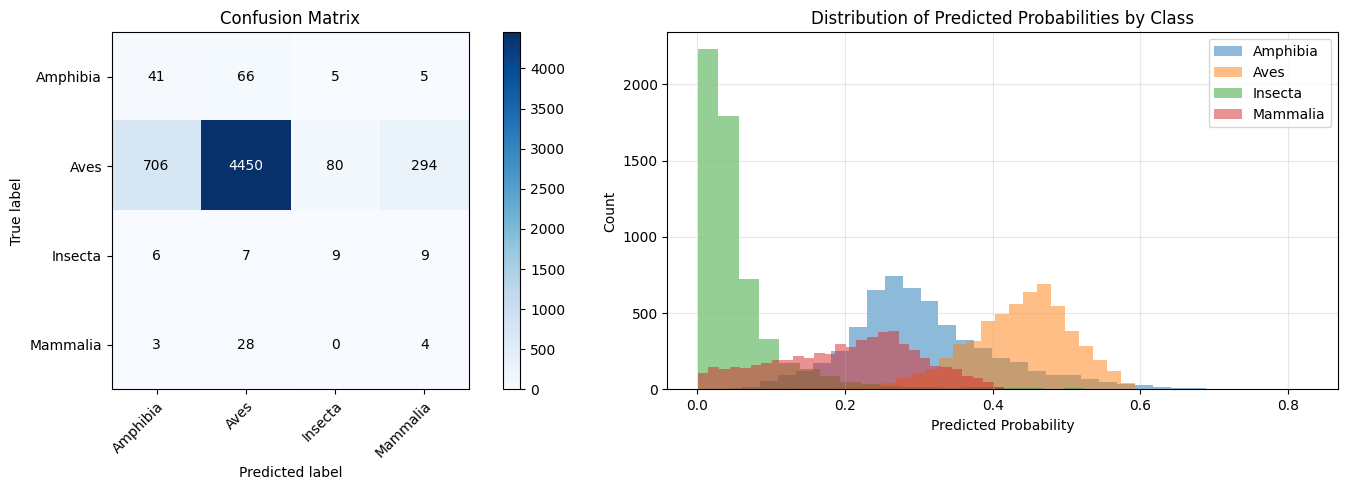

Classification report saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/result_csvs/classification_report_6464_aug_os.csv

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.05      0.35      0.09       117
        Aves       0.98      0.80      0.88      5530
     Insecta       0.10      0.29      0.14        31
    Mammalia       0.01      0.11      0.02        35

    accuracy                           0.79      5713
   macro avg       0.29      0.39      0.29      5713
weighted avg       0.95      0.79      0.86      5713



In [ ]:
# Run evaluation
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
print(f"Test size: {len(test_df)}")

y_true, y_pred_prob = evaluate_on_test(model, cfg, spectrograms, test_df)

plot_training_diagnostics(history, cfg, y_true, y_pred_prob, class_mapping_dict)

# Plot with dictionary
plot_test_evaluation(y_true, y_pred_prob, class_mapping=class_mapping_dict, cfg=cfg)